# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from skimage.draw import rectangle

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

#Make GPUs visible
!export HIP_VISIBLE_DEVICES=0,1,2,3

# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Pull in annotations from database (from Simplot)

In [56]:
import pyodbc
import os
import pandas as pd

DATA_DIR = os.path.join(ROOT_DIR, "../data")

COCO_MODEL_PATH = os.path.join(DATA_DIR, "mask_rcnn_coco.h5")

ANNOTATION_COLS = ['XMax','XMin','YMin','YMax','LabelDescription']

passwd = os.environ['dgs_sandbox_pwd']

conn = pyodbc.connect('DSN=BIdevDatabase;'
                      'Database=Sandbox;'
                      'UID=DGSuser;'
                      'PWD=' + passwd)


class_descriptions = pd.read_sql("SELECT LabelName, LabelDescription from [kaggle].[Class_Description]",conn)

#add 1 since Background class is automatically added at index 0
class_descriptions['LabelID'] = class_descriptions.index + 1

display(class_descriptions.head())

#This now holds the annotation information.
bboxes = pd.read_sql("SELECT ImageID, XMax, XMin, YMin, YMax, LabelName FROM [Sandbox].[kaggle].[Combined_Set_Detection_BBox]", conn)

annotations = pd.merge(bboxes,class_descriptions, on='LabelName',how='inner')

display(annotations.head())

# This now holds the list of images
image_paths = pd.read_sql("SELECT ImageID, RelativePath, Height, Width, Mode from [kaggle].[Image_Path]", conn)

display(image_paths.head())

# Inner join on the two dataframes, so we now have images combined with associated annotations
annotated_image_paths = pd.merge(image_paths,annotations, on='ImageID',how='inner')

display(annotated_image_paths.head())

,LabelName,LabelDescription,LabelID
0,/m/061hd_,Infant bed,1
1,/m/06m11,Rose,2
2,/m/03120,Flag,3
3,/m/01kb5b,Flashlight,4
4,/m/0120dh,Sea turtle,5


,ImageID,XMax,XMin,YMin,YMax,LabelName,LabelDescription,LabelID
0,5a27bbe9ab1ede93,0.706875,0.026250,0.553571,0.999060,/m/04p0qw,Billiard table,47
1,2fe71cd9dc2acfdd,0.999333,0.000000,0.000000,0.998565,/m/04p0qw,Billiard table,47
2,ea2422b5f4c97b42,0.868228,0.000000,0.168945,0.431641,/m/04p0qw,Billiard table,47
3,ea2422b5f4c97b42,0.888726,0.000000,0.567383,0.999023,/m/04p0qw,Billiard table,47
4,2fef02bb3916fec3,0.481250,0.045833,0.402778,0.687963,/m/04p0qw,Billiard table,47


,ImageID,RelativePath,Height,Width,Mode
0,95259d687d440013,train/95259d687d440013.jpg,1024,1024,RGB
1,ccce42a1f4ed2c96,train/ccce42a1f4ed2c96.jpg,1024,768,RGB
2,30723bdea123ccdf,validation/30723bdea123ccdf.jpg,683,1024,RGB
3,cba0bd46fcddd85d,train/cba0bd46fcddd85d.jpg,1024,1024,RGB
4,cc88539b5c74a0c0,train/cc88539b5c74a0c0.jpg,1024,1024,RGB


,ImageID,RelativePath,Height,Width,Mode,XMax,XMin,YMin,YMax,LabelName,LabelDescription,LabelID
0,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.697656,0.089844,0.000000,0.936458,/m/04yx4,Man,114
1,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.388281,0.221875,0.000000,0.309375,/m/0dzct,Human face,280
2,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.960156,0.778906,0.000000,0.300000,/m/0dzct,Human face,280
3,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.332812,0.000000,0.864583,0.998958,/m/050gv4,Plate,473
4,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.946875,0.605469,0.836458,0.998958,/m/050gv4,Plate,473


## Configurations

In [113]:
class KaggleConfig(Config):
    
    NAME = "kaggle"

    #TODO experiment with this
    GPU_COUNT = 4
    IMAGES_PER_GPU = 2  # TODO how many can we use, authors had 2 for 12 GB, we have 32 GB so ...

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(class_descriptions)  # + 1 for background

    #TODO experiment with this
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.75
    
config = KaggleConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      4
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                513
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Utility Functions

In [58]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Subclass utils.Dataset for entire experiment

In [62]:
class FullKaggleImageDataset(utils.Dataset):
         
    def load_kaggle_images(self, dataset_dir, grouped_by_images):
        """Load a subset of the image dataset.
        dataset_dir: The root directory of the image dataset.
        classes: Dataframe : If provided, only loads images that have the given classes.
        """

        # Add classes, BG is automatically added at index 0
        for _,row in class_descriptions.iterrows():
            self.add_class("openImages", row['LabelID'], row['LabelDescription'])
        
#         X = 0
        
        # Add images
        for i,df in grouped_by_images:    
            row = df.iloc[0]
            
#             X += 1
#             if X%10000 == 0:
#                 print(X)
            
            self.add_image(
                "openImages", image_id=i,
                path=os.path.join(dataset_dir, row['RelativePath']),
                width=row["Width"],
                height=row["Height"],
                annotations=df)
    

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        # Create rectangular bounding box since we are doing object detection, not segmentation
        # desired dimension is [height, width, instance_count]
        img = self.image_info[image_id]
        
        mask = np.zeros([img["height"], img["width"], len(img["annotations"])],
                        dtype=np.uint8)
        
        for i,(_,p) in enumerate(img["annotations"].iterrows()):
            # Create rectangular bounding box since we are doing object detection, not segmentation
    
            xmax = int(img["width"]*p['XMax'])
            xmin = int(img["width"]*p['XMin'])
            ymin = int(img["height"]*p['YMin'])
            ymax = int(img["height"]*p['YMax'])
            
            start = (ymin, xmin)  #top left corner ... are coordinates reversed?
            end = (ymax, xmax)  #height and width
            rr, cc = rectangle(start, end=end, shape=(img["height"],img["width"]))
            
            mask[rr, cc, i] = 1

        
        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), np.array(img['annotations']['LabelID'].values, dtype=np.int32)

    def image_reference(self, image_id):
        return self.image_info[image_id]['path']
    

## Load dataset and display samples

### Instantiate the Full Kaggle Image Dataset classes

In [ ]:
val_paths = annotated_image_paths[annotated_image_paths['RelativePath'].str.contains('validation',regex=False)]
train_paths = annotated_image_paths[annotated_image_paths['RelativePath'].str.contains('train',regex=False)]

val_grouped = val_paths.groupby('ImageID')
train_grouped = train_paths.groupby('ImageID')

# Training dataset
dataset_train = FullKaggleImageDataset()
dataset_train.load_kaggle_images(DATA_DIR, train_grouped)
dataset_train.prepare()

# Validation dataset
dataset_val = FullKaggleImageDataset()
dataset_val.load_kaggle_images(DATA_DIR, val_grouped)
dataset_val.prepare()

In [ ]:
# Load and display random samples ... sanity check for data load
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [75]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [76]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/nbuser/repo/logs/kaggle20190807T1755/mask_rcnn_kaggle_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4

100/100 [==============================] - 38s 378ms/step - loss: 1.5802 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.2735 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3065 - val_loss: 10.9730 - val_rpn_class_loss: 0.4965 - val_rpn_bbox_loss: 8.1627 - val_mrcnn_class_loss: 0.9527 - val_mrcnn_bbox_loss: 0.8139 - val_mrcnn_mask_loss: 0.5471
Epoch 20/100
100/100 [==============================] - 38s 378ms/step - loss: 1.6041 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 0.7047 - mrcnn_class_loss: 0.2893 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.2940 - val_loss: 5.3119 - val_rpn_class_loss: 0.2182 - val_rpn_bbox_loss: 2.9483 - val_mrcnn_class_loss: 0.9132 - val_mrcnn_bbox_loss: 0.6851 - val_mrcnn_mask_loss: 0.5471
Epoch 21/100
100/100 [==============================] - 41s 412ms/step - loss: 2.0864 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 1.1600 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.3351 - val_loss: 6.2986 - val_rpn_class_l

100/100 [==============================] - 38s 379ms/step - loss: 1.3718 - rpn_class_loss: 0.0943 - rpn_bbox_loss: 0.4154 - mrcnn_class_loss: 0.2929 - mrcnn_bbox_loss: 0.2459 - mrcnn_mask_loss: 0.3232 - val_loss: 3.6317 - val_rpn_class_loss: 0.2028 - val_rpn_bbox_loss: 1.4230 - val_mrcnn_class_loss: 0.8539 - val_mrcnn_bbox_loss: 0.5699 - val_mrcnn_mask_loss: 0.5822
Epoch 41/100
100/100 [==============================] - 37s 367ms/step - loss: 1.2520 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 0.4044 - mrcnn_class_loss: 0.2835 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.2809 - val_loss: 3.9903 - val_rpn_class_loss: 0.1283 - val_rpn_bbox_loss: 1.5495 - val_mrcnn_class_loss: 0.6592 - val_mrcnn_bbox_loss: 0.7411 - val_mrcnn_mask_loss: 0.9123
Epoch 42/100
100/100 [==============================] - 38s 378ms/step - loss: 1.1738 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.1547 - mrcnn_mask_loss: 0.2502 - val_loss: 3.3929 - val_rpn_class_lo

100/100 [==============================] - 38s 377ms/step - loss: 1.4736 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 0.5963 - mrcnn_class_loss: 0.2978 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.2883 - val_loss: 4.2636 - val_rpn_class_loss: 0.2524 - val_rpn_bbox_loss: 2.2807 - val_mrcnn_class_loss: 0.8917 - val_mrcnn_bbox_loss: 0.5601 - val_mrcnn_mask_loss: 0.2787
Epoch 62/100
100/100 [==============================] - 37s 375ms/step - loss: 0.8997 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.2588 - mrcnn_class_loss: 0.1862 - mrcnn_bbox_loss: 0.1582 - mrcnn_mask_loss: 0.2480 - val_loss: 3.6916 - val_rpn_class_loss: 0.1364 - val_rpn_bbox_loss: 1.6269 - val_mrcnn_class_loss: 0.8945 - val_mrcnn_bbox_loss: 0.6889 - val_mrcnn_mask_loss: 0.3448
Epoch 63/100
100/100 [==============================] - 37s 370ms/step - loss: 1.0000 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.2400 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.2686 - val_loss: 7.2012 - val_rpn_class_lo

100/100 [==============================] - 36s 364ms/step - loss: 1.2423 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 0.3276 - mrcnn_class_loss: 0.3225 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.3056 - val_loss: 4.3499 - val_rpn_class_loss: 0.3602 - val_rpn_bbox_loss: 2.1517 - val_mrcnn_class_loss: 0.9128 - val_mrcnn_bbox_loss: 0.5305 - val_mrcnn_mask_loss: 0.3946
Epoch 83/100
100/100 [==============================] - 36s 359ms/step - loss: 1.1042 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.3928 - mrcnn_class_loss: 0.2194 - mrcnn_bbox_loss: 0.1728 - mrcnn_mask_loss: 0.2560 - val_loss: 6.1942 - val_rpn_class_loss: 0.3964 - val_rpn_bbox_loss: 3.4278 - val_mrcnn_class_loss: 1.3758 - val_mrcnn_bbox_loss: 0.5762 - val_mrcnn_mask_loss: 0.4179
Epoch 84/100
100/100 [==============================] - 35s 354ms/step - loss: 1.1661 - rpn_class_loss: 0.0589 - rpn_bbox_loss: 0.3988 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.1916 - mrcnn_mask_loss: 0.2744 - val_loss: 4.1190 - val_rpn_class_lo

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [108]:
class InferenceConfig(KaggleConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    BATCH_SIZE = 10

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/nbuser/repo/logs/kaggle20190807T1755/mask_rcnn_kaggle_0100.h5
Re-starting from epoch 100


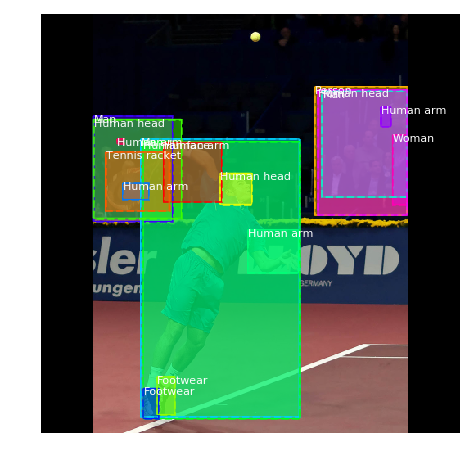

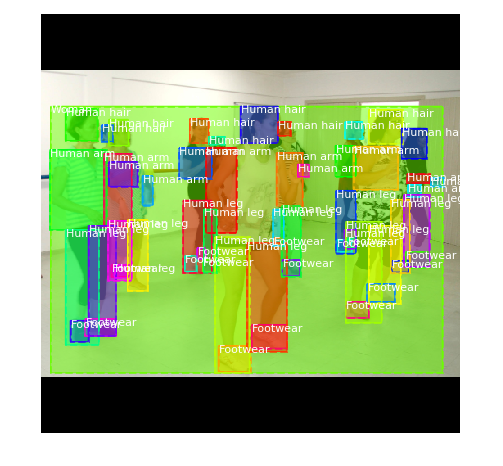

In [109]:
#test on a few random images
image_ids = np.random.choice(dataset_val.image_ids, inference_config.BATCH_SIZE)

images = []

for iid in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, iid, use_mini_mask=False)

    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))
    
    images.append(original_image)


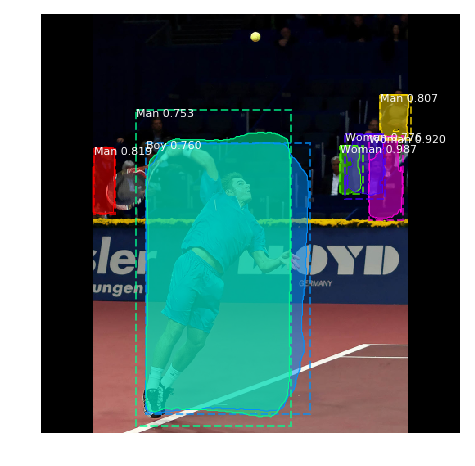

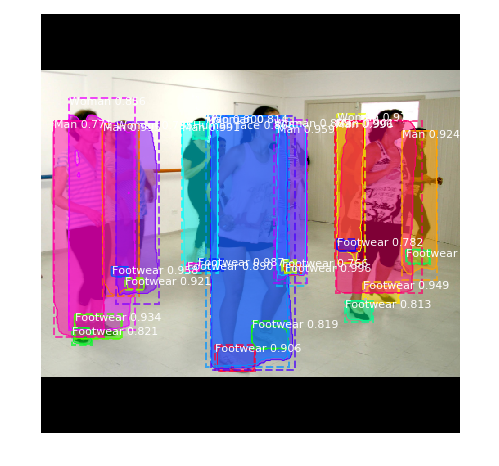

In [110]:
results = model.detect(images, verbose=0)

for i in range(len(results)):
    r = results[i]
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [112]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 500)

#each input is a tuple of form : image, image_meta, gt_class_id, gt_bbox, gt_mask
inputs = [modellib.load_image_gt(dataset_val, inference_config, iid, use_mini_mask=False) for iid in image_ids]

APs = []

n = inference_config.BATCH_SIZE

for i in range(0,len(image_ids),n): 

    curr_inputs = inputs[i:i+n]
    
    results = model.detect([inp[0] for inp in curr_inputs], verbose=0)
    
    for j in range(len(results)):
        r = results[j]
        # Compute AP
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(curr_inputs[j][3], curr_inputs[j][2], curr_inputs[j][4],
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.08220428757809495
